# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [45]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [46]:
bulkPath = '../nf_output_SH1000/countData/countData.tsv'
metaPath = '../Finstrlova_SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output_SH1000/alignments/dualGenome.gff3' # output from nf pipeline

In [47]:
# Load data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)
metadata = metadata[metadata['strain'] == 'SH1000']

In [48]:
df_initial.head()

,Chr,Start,End,Strand,Length,SRR17196372_sorted.bam,SRR17196375_sorted.bam,SRR17196376_sorted.bam,SRR17196373_sorted.bam,SRR17196381_sorted.bam,...,SRR17196367_sorted.bam,SRR17196382_sorted.bam,SRR17196365_sorted.bam,SRR17196374_sorted.bam,SRR17196378_sorted.bam,SRR17196385_sorted.bam,SRR17196380_sorted.bam,SRR17196377_sorted.bam,SRR17196383_sorted.bam,SRR17196366_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-SAURSH1000_RS00005,NZ_CP059180.1,1,1362,+,1362,1172,1044,378,785,339,...,745,95,681,1343,1121,46,289,819,157,1461
gene-SAURSH1000_RS00010,NZ_CP059180.1,1640,2773,+,1134,1264,1371,520,970,367,...,937,127,922,1735,1335,78,359,1028,217,1525
gene-SAURSH1000_RS00015,NZ_CP059180.1,3154,3399,+,246,237,322,147,241,94,...,252,48,265,331,297,38,86,238,39,342
gene-SAURSH1000_RS00020,NZ_CP059180.1,3396,4508,+,1113,1171,1328,545,926,451,...,957,160,1017,1275,1243,98,285,862,184,1414
gene-SAURSH1000_RS00025,NZ_CP059180.1,4518,6452,+,1935,2456,2712,982,1384,757,...,1836,321,1986,2374,2584,217,608,1444,337,2555


In [49]:
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,...,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time
0,SRR17196365,RNA-Seq,76,1057547372,PRJNA787900,SAMN23849066,433771809,GEO,public,"fastq,run.zq,sra",...,Staphylococcus aureus,ILLUMINA,2022-03-24T00:00:00Z,2021-12-10T15:14:00Z,1,GSM5726888,Staphylococcus aureus SH1000 growing exponenti...,SRP350254,SH1000,before infection
1,SRR17196366,RNA-Seq,76,1092607464,PRJNA787900,SAMN23849067,452952701,GEO,public,"fastq,run.zq,sra",...,Staphylococcus aureus,ILLUMINA,2022-03-24T00:00:00Z,2021-12-10T15:14:00Z,1,GSM5726889,Staphylococcus aureus SH1000 growing exponenti...,SRP350254,SH1000,before infection
2,SRR17196367,RNA-Seq,76,964420620,PRJNA787900,SAMN23849068,399683790,GEO,public,"fastq,run.zq,sra",...,Staphylococcus aureus,ILLUMINA,2022-03-24T00:00:00Z,2021-12-10T15:12:00Z,1,GSM5726890,Staphylococcus aureus SH1000 growing exponenti...,SRP350254,SH1000,before infection
3,SRR17196368,RNA-Seq,76,948685732,PRJNA787900,SAMN23849069,389404558,GEO,public,"fastq,run.zq,sra",...,Staphylococcus aureus,ILLUMINA,2022-03-24T00:00:00Z,2021-12-10T15:11:00Z,1,GSM5726891,Staphylococcus aureus SH1000 growing exponenti...,SRP350254,SH1000,0 min
4,SRR17196369,RNA-Seq,76,870143988,PRJNA787900,SAMN23849070,359081229,GEO,public,"fastq,run.zq,sra",...,Staphylococcus aureus,ILLUMINA,2022-03-24T00:00:00Z,2021-12-10T15:12:00Z,1,GSM5726892,Staphylococcus aureus SH1000 growing exponenti...,SRP350254,SH1000,0 min
5,SRR17196370,RNA-Seq,76,664394584,PRJNA787900,SAMN23849071,277362355,GEO,public,"fastq,run.zq,sra",...,Staphylococcus aureus,ILLUMINA,2022-03-24T00:00:00Z,2021-12-10T15:12:00Z,1,GSM5726893,Staphylococcus aureus SH1000 growing exponenti...,SRP350254,SH1000,0 min
6,SRR17196371,RNA-Seq,76,1042490860,PRJNA787900,SAMN23849072,427405212,GEO,public,"fastq,run.zq,sra",...,Staphylococcus aureus,ILLUMINA,2022-03-24T00:00:00Z,2021-12-10T15:13:00Z,1,GSM5726894,Staphylococcus aureus SH1000 growing exponenti...,SRP350254,SH1000,2 min
7,SRR17196372,RNA-Seq,76,722015276,PRJNA787900,SAMN23849073,299843267,GEO,public,"fastq,run.zq,sra",...,Staphylococcus aureus,ILLUMINA,2022-03-24T00:00:00Z,2021-12-10T15:12:00Z,1,GSM5726895,Staphylococcus aureus SH1000 growing exponenti...,SRP350254,SH1000,2 min
8,SRR17196373,RNA-Seq,76,1012488568,PRJNA787900,SAMN23849074,421511286,GEO,public,"fastq,run.zq,sra",...,Staphylococcus aureus,ILLUMINA,2022-03-24T00:00:00Z,2021-12-10T15:13:00Z,1,GSM5726896,Staphylococcus aureus SH1000 growing exponenti...,SRP350254,SH1000,2 min
9,SRR17196374,RNA-Seq,76,877477988,PRJNA787900,SAMN23849075,359359570,GEO,public,"fastq,run.zq,sra",...,Staphylococcus aureus,ILLUMINA,2022-03-24T00:00:00Z,2021-12-10T15:13:00Z,1,GSM5726897,Staphylococcus aureus SH1000 growing exponenti...,SRP350254,SH1000,5 min


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [50]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM5726888': '-1_R1', 'GSM5726889': '-1_R2', 'GSM5726890': '-1_R3',
              'GSM5726891': '0_R1', 'GSM5726892': '0_R2', 'GSM5726893': '0_R3',
              'GSM5726894': '2_R1', 'GSM5726895': '2_R2', 'GSM5726896': '2_R3',
              'GSM5726897': '5_R1', 'GSM5726898': '5_R2', 'GSM5726899': '5_R3',
              'GSM5726900': '10_R1', 'GSM5726901': '10_R2', 'GSM5726902': '10_R3',
              'GSM5726903': '20_R1', 'GSM5726904': '20_R2', 'GSM5726905': '20_R3',
              'GSM5726906': '30_R1', 'GSM5726907': '30_R2', 'GSM5726908': '30_R3',
}

In [51]:
metadataFull = annotateData(metadata, sampleDict)

In [52]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,...,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time
0,SRR17196365,RNA-Seq,76,1057547372,PRJNA787900,SAMN23849066,433771809,GEO,public,"fastq,run.zq,sra",...,Staphylococcus aureus,ILLUMINA,2022-03-24T00:00:00Z,2021-12-10T15:14:00Z,1,GSM5726888,Staphylococcus aureus SH1000 growing exponenti...,SRP350254,SH1000,before infection


In [53]:
metadataFull.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,...,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,
SRR17196365_sorted.bam,SRR17196365,RNA-Seq,76,1057547372,PRJNA787900,SAMN23849066,433771809,GEO,public,"fastq,run.zq,sra",...,2022-03-24T00:00:00Z,2021-12-10T15:14:00Z,1,GSM5726888,Staphylococcus aureus SH1000 growing exponenti...,SRP350254,SH1000,before infection,SRR17196365_sorted.bam,-1_R1


Add correct sample names.

In [54]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['-1_R1', '-1_R2', '-1_R3', '0_R1', '0_R2', '0_R3', '2_R1', '2_R2', '2_R3',
         '5_R1', '5_R2', '5_R3', '10_R1', '10_R2', '10_R3', '20_R1', '20_R2', '20_R3', '30_R1', '30_R2', '30_R3']]
df

SampleNames,-1_R1,-1_R2,-1_R3,0_R1,0_R2,0_R3,2_R1,2_R2,2_R3,5_R1,...,5_R3,10_R1,10_R2,10_R3,20_R1,20_R2,20_R3,30_R1,30_R2,30_R3
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-SAURSH1000_RS00005,681,1461,745,930,1344,786,1163,1172,785,1343,...,378,819,1121,189,289,339,95,157,327,46
gene-SAURSH1000_RS00010,922,1525,937,1286,1466,894,1497,1264,970,1735,...,520,1028,1335,260,359,367,127,217,382,78
gene-SAURSH1000_RS00015,265,342,252,339,265,213,424,237,241,331,...,147,238,297,90,86,94,48,39,91,38
gene-SAURSH1000_RS00020,1017,1414,957,1198,1089,992,1410,1171,926,1275,...,545,862,1243,318,285,451,160,184,389,98
gene-SAURSH1000_RS00025,1986,2555,1836,2010,2096,1931,2468,2456,1384,2374,...,982,1444,2584,679,608,757,321,337,774,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp037,0,0,0,5,0,10,293,39,262,1510,...,832,1313,1110,745,293,331,675,206,183,427
gene-CPT_phageK_gp036,0,0,1,15,1,16,666,119,474,3264,...,2254,3525,3213,2491,1748,1302,2546,942,912,1275
gene-CPT_phageK_gp035,0,0,1,5,2,4,269,55,202,1553,...,1044,1651,1549,1254,442,544,979,247,314,581


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [55]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [56]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_005880.2_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_005880.2"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
2603,NC_005880.2,RefSeq,gene,486.0,785.0,.,+,.,gene-CPT_phageK_gp001,CPT_phageK_gp001,Gene,protein_coding,CPT_phageK_gp001,gene-CPT_phageK_gp001,hypothetical protein,hypothetical protein,654.0,unknown function
2604,NC_005880.2,RefSeq,gene,801.0,986.0,.,+,.,gene-CPT_phageK_gp002,CPT_phageK_gp002,Gene,protein_coding,CPT_phageK_gp002,gene-CPT_phageK_gp002,hypothetical protein,hypothetical protein,3204.0,unknown function
2605,NC_005880.2,RefSeq,gene,1093.0,1380.0,.,+,.,gene-CPT_phageK_gp003,CPT_phageK_gp003,Gene,protein_coding,CPT_phageK_gp003,gene-CPT_phageK_gp003,hypothetical protein,hypothetical protein,654.0,unknown function
2606,NC_005880.2,RefSeq,gene,1380.0,1706.0,.,+,.,gene-CPT_phageK_gp004,CPT_phageK_gp004,Gene,protein_coding,CPT_phageK_gp004,gene-CPT_phageK_gp004,hypothetical protein,hypothetical protein,654.0,unknown function
2607,NC_005880.2,RefSeq,gene,1722.0,2015.0,.,+,.,gene-CPT_phageK_gp005,CPT_phageK_gp005,Gene,protein_coding,CPT_phageK_gp005,gene-CPT_phageK_gp005,hypothetical protein,hypothetical protein,654.0,unknown function
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835,NC_005880.2,RefSeq,gene,146607.0,146843.0,.,+,.,gene-CPT_phageK_gp037,CPT_phageK_gp037,Gene,protein_coding,CPT_phageK_gp037,gene-CPT_phageK_gp037,hypothetical protein,hypothetical protein,3480.0,unknown function
2836,NC_005880.2,RefSeq,gene,146923.0,147393.0,.,+,.,gene-CPT_phageK_gp036,CPT_phageK_gp036,Gene,protein_coding,CPT_phageK_gp036,gene-CPT_phageK_gp036,hypothetical protein,hypothetical protein,2543.0,unknown function
2837,NC_005880.2,RefSeq,gene,147452.0,147625.0,.,+,.,gene-CPT_phageK_gp035,CPT_phageK_gp035,Gene,protein_coding,CPT_phageK_gp035,gene-CPT_phageK_gp035,hypothetical protein,hypothetical protein,3789.0,unknown function
2838,NC_005880.2,RefSeq,gene,147625.0,147894.0,.,+,.,gene-CPT_phageK_gp034,CPT_phageK_gp034,Gene,protein_coding,CPT_phageK_gp034,gene-CPT_phageK_gp034,hypothetical protein,hypothetical protein,3549.0,unknown function


In [57]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'NC_005880.2', 'phage', 'host')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [58]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,-1_R1,-1_R2,-1_R3,0_R1,0_R2,0_R3,2_R1,2_R2,2_R3,5_R1,...,5_R3,10_R1,10_R2,10_R3,20_R1,20_R2,20_R3,30_R1,30_R2,30_R3
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-SAURSH1000_RS00755,151,243,137,322,184,173,311,224,204,407,...,104,255,244,57,55,105,27,60,61,19
gene-SAURSH1000_RS10935,225,303,251,287,301,224,369,364,240,341,...,146,251,589,83,96,164,23,58,174,23
gene-SAURSH1000_RS03700,448,547,515,671,597,612,834,663,561,954,...,286,545,702,142,154,203,69,137,195,48
gene-SAURSH1000_RS06540,17583,13409,11305,24611,8539,7779,26542,7629,11416,23030,...,10790,15387,12166,5912,6794,3241,3091,5497,3186,1702
gene-SAURSH1000_RS01440,86,72,114,82,57,122,84,73,72,79,...,46,42,40,16,15,25,12,7,20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp031,0,0,0,101,1,0,14,1,2,250,...,570,1446,902,1179,3734,2276,6329,11702,5144,7329
gene-SAURSH1000_RS01180,39,61,34,38,53,27,50,48,31,41,...,23,30,66,13,27,20,3,11,20,4
gene-CPT_phageK_gp024,0,0,0,14,0,1,6,3,1,458,...,619,3561,1297,2425,1934,1927,2141,1413,1544,580


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [59]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [60]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,-1_R1,-1_R2,-1_R3,0_R1,0_R2,0_R3,2_R1,2_R2,2_R3,5_R1,...,10_R2,10_R3,20_R1,20_R2,20_R3,30_R1,30_R2,30_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-SAURSH1000_RS00755,16.053755,42.272475,23.386313,41.025828,37.042809,46.500718,37.456117,46.272232,39.143157,48.802848,...,30.383765,13.981238,9.480429,29.646207,6.021863,11.490406,14.352241,5.278246,host,gene-SAURSH1000_RS00755
gene-SAURSH1000_RS10935,20.043430,44.195588,35.880507,30.677997,50.775752,50.470550,37.268392,63.017788,38.613497,34.305976,...,61.448042,17.030436,13.826868,38.774311,4.316458,9.319602,34.158717,5.335614,host,gene-SAURSH1000_RS10935
gene-SAURSH1000_RS03700,27.822203,55.642664,51.327820,50.007914,70.228037,96.101762,58.743000,80.058992,62.918358,66.920407,...,51.106264,20.284193,15.450003,33.476972,8.909392,15.287898,26.708928,7.685319,host,gene-SAURSH1000_RS03700
gene-SAURSH1000_RS06540,7814.493471,9763.438869,8064.554071,13130.983033,7190.705411,8744.669053,13385.606191,6595.256677,9164.885308,11567.844485,...,6341.031378,6029.488212,4867.702479,3820.271446,2839.219212,4379.018117,3118.818144,1932.741145,host,cspA
gene-SAURSH1000_RS01440,23.204031,31.862515,49.300111,26.568371,29.225283,83.115038,25.722001,38.350832,35.130464,24.102829,...,12.740929,10.156523,6.702704,18.140122,6.929334,3.605991,12.111050,3.768783,host,gene-SAURSH1000_RS01440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp031,0.080476,0.131845,0.129171,19.612289,0.457439,0.203547,2.648301,0.469602,0.726837,45.567991,...,170.350937,435.622513,968.951548,971.670293,2105.242616,3375.928407,1823.569733,3013.450035,phage,gene-CPT_phageK_gp031
gene-SAURSH1000_RS01180,3.946855,10.067552,5.533096,4.618260,10.128646,6.949970,5.725931,9.426184,5.685428,4.686576,...,7.792457,3.095292,4.429531,5.432010,0.722697,2.059529,4.511163,1.148570,host,gene-SAURSH1000_RS01180
gene-CPT_phageK_gp024,0.175155,0.286957,0.281136,6.097938,0.331868,1.329042,2.583839,2.384842,0.949164,181.528280,...,533.037159,1949.693988,1092.423751,1790.599505,1550.256746,887.489439,1191.570984,519.451103,phage,gene-CPT_phageK_gp024


In [61]:
# Check gene names unique
len(tpms['Symbol'].unique())

2821

Log2+1 normalization raw counts

In [62]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,-1_R1,-1_R2,-1_R3,0_R1,0_R2,0_R3,2_R1,2_R2,2_R3,5_R1,...,10_R2,10_R3,20_R1,20_R2,20_R3,30_R1,30_R2,30_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-SAURSH1000_RS00755,7.247928,7.930737,7.108524,8.335390,7.531381,7.442943,8.285402,7.813781,7.679480,8.672425,...,7.936638,5.857981,5.807355,6.727920,4.807355,5.930737,5.954196,4.321928,host,gene-SAURSH1000_RS00755
gene-SAURSH1000_RS10935,7.820179,8.247928,7.977280,8.169925,8.238405,7.813781,8.531381,8.511753,7.912889,8.417853,...,9.204571,6.392317,6.599913,7.366322,4.584963,5.882643,7.451211,4.584963,host,gene-SAURSH1000_RS10935
gene-SAURSH1000_RS03700,8.810572,9.098032,9.011227,9.392317,9.224002,9.259743,9.705632,9.375039,9.134426,9.899357,...,9.457381,7.159871,7.276124,7.672425,6.129283,7.108524,7.614710,5.614710,host,gene-SAURSH1000_RS03700
gene-SAURSH1000_RS06540,14.101976,13.711022,13.464801,14.587074,13.060020,12.925554,14.696044,12.897467,13.478896,14.491289,...,13.570686,12.529675,12.730258,11.662668,11.594325,12.424691,11.637983,10.733863,host,cspA
gene-SAURSH1000_RS01440,6.442943,6.189825,6.845490,6.375039,5.857981,6.942515,6.409391,6.209453,6.189825,6.321928,...,5.357552,4.087463,4.000000,4.700440,3.700440,3.000000,4.392317,2.584963,host,gene-SAURSH1000_RS01440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp031,0.000000,0.000000,0.000000,6.672425,1.000000,0.000000,3.906891,1.000000,1.584963,7.971544,...,9.818582,10.204571,11.866893,11.152919,12.627990,13.514591,12.328955,12.839597,phage,gene-CPT_phageK_gp031
gene-SAURSH1000_RS01180,5.321928,5.954196,5.129283,5.285402,5.754888,4.807355,5.672425,5.614710,5.000000,5.392317,...,6.066089,3.807355,4.807355,4.392317,2.000000,3.584963,4.392317,2.321928,host,gene-SAURSH1000_RS01180
gene-CPT_phageK_gp024,0.000000,0.000000,0.000000,3.906891,0.000000,1.000000,2.807355,2.000000,1.000000,8.842350,...,10.342075,11.244364,10.918118,10.912889,11.064743,10.465566,10.593391,9.182394,phage,gene-CPT_phageK_gp024


Log2+1 normalization tpms

In [63]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,-1_R1,-1_R2,-1_R3,0_R1,0_R2,0_R3,2_R1,2_R2,2_R3,5_R1,...,10_R2,10_R3,20_R1,20_R2,20_R3,30_R1,30_R2,30_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-SAURSH1000_RS00755,4.092018,5.435378,4.608000,5.393204,5.249552,5.569877,5.265141,5.562921,5.327082,5.638156,...,4.971947,3.905085,3.389626,4.937637,2.811854,3.642748,3.940377,2.650362,host,gene-SAURSH1000_RS00755
gene-SAURSH1000_RS10935,4.395298,5.498110,5.204787,4.985409,5.694205,5.685675,5.258081,6.000401,5.307920,5.141840,...,5.964584,4.172362,3.890142,5.313765,2.410465,3.367315,5.135811,2.663485,host,gene-SAURSH1000_RS10935
gene-SAURSH1000_RS03700,4.849109,5.823817,5.709506,5.672649,6.154373,6.601426,5.900698,6.340900,5.998158,6.085773,...,5.703385,4.411710,4.040016,5.107561,3.308796,4.025728,4.792279,3.118579,host,gene-SAURSH1000_RS03700
gene-SAURSH1000_RS06540,12.932121,13.253321,12.977558,13.680797,12.812118,13.094353,13.708503,12.687432,13.162059,13.497957,...,12.630729,12.558059,12.249322,11.899837,11.471787,12.096721,11.607246,10.917179,host,cspA
gene-SAURSH1000_RS01440,4.597175,5.038371,5.652490,4.784942,4.917684,6.394292,4.739956,5.298322,5.175144,4.649778,...,3.780408,3.479816,2.945365,4.258528,2.987200,2.203511,3.712711,2.253621,host,gene-SAURSH1000_RS01440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp031,0.111668,0.178676,0.175263,4.365433,0.543436,0.267293,1.867225,0.555426,0.788132,5.541267,...,7.420810,8.770243,9.921769,9.925807,11.040456,11.721496,10.833341,11.557679,phage,gene-CPT_phageK_gp031
gene-SAURSH1000_RS01180,2.306512,3.468264,2.707767,2.490124,3.476206,2.990949,2.749734,3.382139,2.741020,2.507560,...,3.136266,2.033966,2.440828,2.685270,0.784669,1.613310,2.462357,1.103377,host,gene-SAURSH1000_RS01180
gene-CPT_phageK_gp024,0.232850,0.363963,0.357424,2.827400,0.413451,1.219737,1.841506,1.759088,0.962855,7.511976,...,9.060796,10.929772,10.094637,10.807032,10.599222,9.795211,10.219859,9.023619,phage,gene-CPT_phageK_gp024


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [64]:
columnOrder = ['-1_R1', '-1_R2', '-1_R3', '0_R1', '0_R2', '0_R3', '2_R1', '2_R2', '2_R3',
               '5_R1', '5_R2', '5_R3', '10_R1', '10_R2', '10_R3', '20_R1', '20_R2', '20_R3', '30_R1', '30_R2', '30_R3']

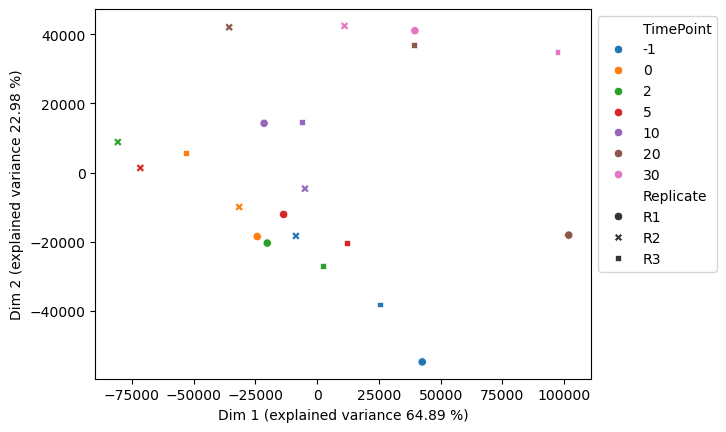

In [65]:
txPCA(tpms[columnOrder])

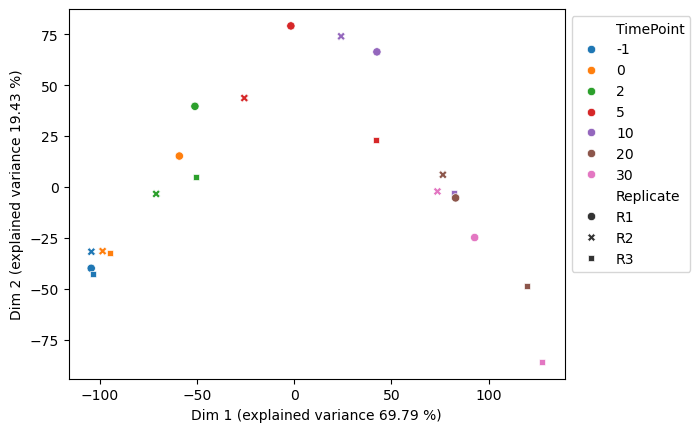

In [66]:
txPCA(logs[columnOrder])

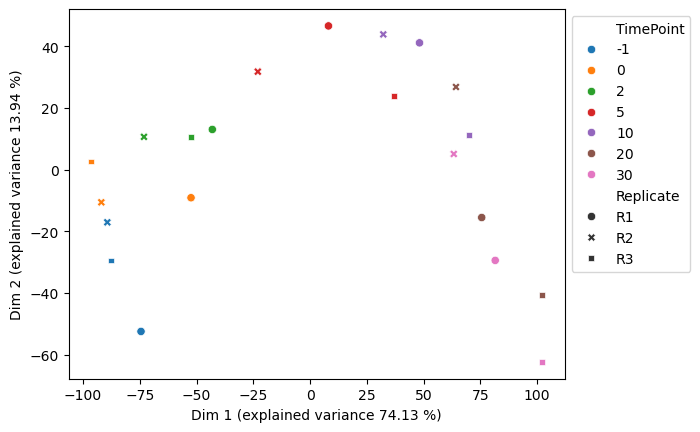

In [67]:
txPCA(logTPMs[columnOrder])

In [68]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

In [69]:
logTPMs

SampleNames,-1_R1,-1_R2,-1_R3,0_R1,0_R2,0_R3,2_R1,2_R2,2_R3,5_R1,...,10_R2,10_R3,20_R1,20_R2,20_R3,30_R1,30_R2,30_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-SAURSH1000_RS00755,4.092018,5.435378,4.608000,5.393204,5.249552,5.569877,5.265141,5.562921,5.327082,5.638156,...,4.971947,3.905085,3.389626,4.937637,2.811854,3.642748,3.940377,2.650362,host,gene-SAURSH1000_RS00755
gene-SAURSH1000_RS10935,4.395298,5.498110,5.204787,4.985409,5.694205,5.685675,5.258081,6.000401,5.307920,5.141840,...,5.964584,4.172362,3.890142,5.313765,2.410465,3.367315,5.135811,2.663485,host,gene-SAURSH1000_RS10935
gene-SAURSH1000_RS03700,4.849109,5.823817,5.709506,5.672649,6.154373,6.601426,5.900698,6.340900,5.998158,6.085773,...,5.703385,4.411710,4.040016,5.107561,3.308796,4.025728,4.792279,3.118579,host,gene-SAURSH1000_RS03700
gene-SAURSH1000_RS06540,12.932121,13.253321,12.977558,13.680797,12.812118,13.094353,13.708503,12.687432,13.162059,13.497957,...,12.630729,12.558059,12.249322,11.899837,11.471787,12.096721,11.607246,10.917179,host,cspA
gene-SAURSH1000_RS01440,4.597175,5.038371,5.652490,4.784942,4.917684,6.394292,4.739956,5.298322,5.175144,4.649778,...,3.780408,3.479816,2.945365,4.258528,2.987200,2.203511,3.712711,2.253621,host,gene-SAURSH1000_RS01440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp031,0.111668,0.178676,0.175263,4.365433,0.543436,0.267293,1.867225,0.555426,0.788132,5.541267,...,7.420810,8.770243,9.921769,9.925807,11.040456,11.721496,10.833341,11.557679,phage,gene-CPT_phageK_gp031
gene-SAURSH1000_RS01180,2.306512,3.468264,2.707767,2.490124,3.476206,2.990949,2.749734,3.382139,2.741020,2.507560,...,3.136266,2.033966,2.440828,2.685270,0.784669,1.613310,2.462357,1.103377,host,gene-SAURSH1000_RS01180
gene-CPT_phageK_gp024,0.232850,0.363963,0.357424,2.827400,0.413451,1.219737,1.841506,1.759088,0.962855,7.511976,...,9.060796,10.929772,10.094637,10.807032,10.599222,9.795211,10.219859,9.023619,phage,gene-CPT_phageK_gp024


tpmHost

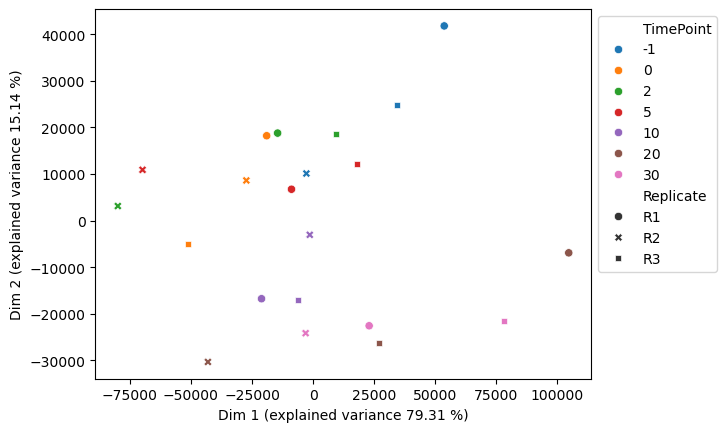

In [70]:
txPCA(tpmHost[columnOrder])

tpmPhage

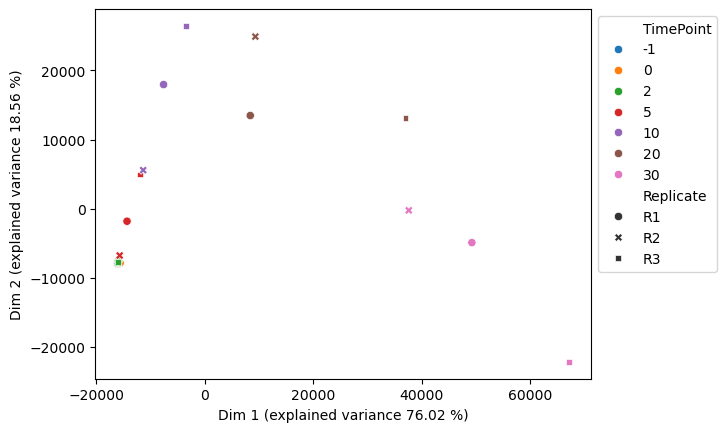

In [71]:
txPCA(tpmPhage[columnOrder])

logTPM Host

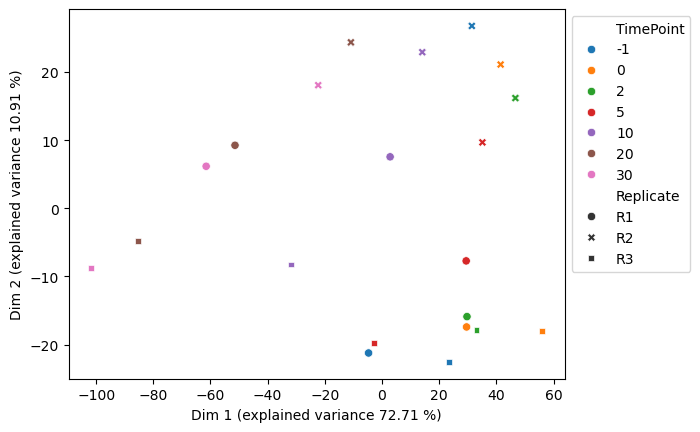

In [72]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

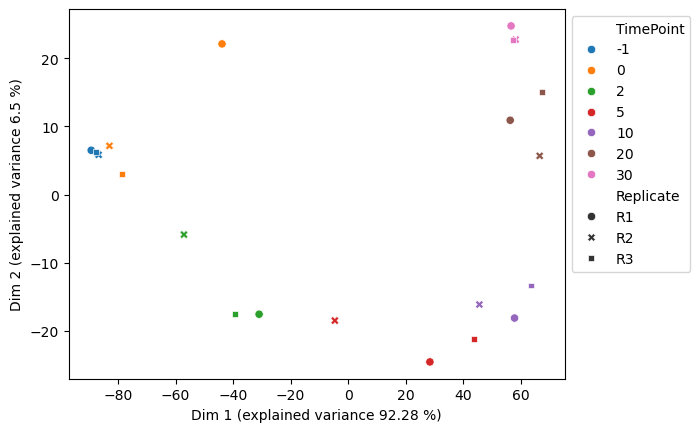

In [73]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Replicates seem to be fine (not perfect, but no clear outliers detectable)

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [74]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['-1', '0', '2', '5', '10', '20', '30']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,-1,0,2,5,10,20,30,Entity,Symbol
Geneid,,,,,,,,,
gene-SAURSH1000_RS00755,27.237514,41.523118,40.957169,33.502696,26.519492,15.049500,10.373631,host,gene-SAURSH1000_RS00755
gene-SAURSH1000_RS10935,33.373175,43.974766,46.299892,38.653832,35.845604,18.972546,16.271311,host,gene-SAURSH1000_RS10935
gene-SAURSH1000_RS03700,44.930896,72.112571,67.240117,55.485247,38.459379,19.278789,16.560715,host,gene-SAURSH1000_RS03700
gene-SAURSH1000_RS06540,8547.495471,9688.785832,9715.249392,9029.714608,7086.628595,3842.397712,3143.525802,host,cspA
gene-SAURSH1000_RS01440,34.788886,46.302897,33.067766,23.329097,12.572430,10.590720,6.495275,host,gene-SAURSH1000_RS01440
...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp031,0.113831,6.757758,1.281580,75.472075,302.870666,1348.621486,2737.649392,phage,gene-CPT_phageK_gp031
gene-SAURSH1000_RS01180,6.515834,7.232292,6.945848,6.161888,4.949754,3.528080,2.573087,host,gene-SAURSH1000_RS01180
gene-CPT_phageK_gp024,0.247749,2.586283,1.972615,203.251877,1368.169905,1477.760001,866.170508,phage,gene-CPT_phageK_gp024


In [75]:
TPMsds = TPMsds[['-1', '0', '2', '5', '10', '20', '30']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,-1,0,2,5,10,20,30,Entity,Symbol
Geneid,,,,,,,,,
gene-SAURSH1000_RS00755,11.044731,3.877154,3.820903,11.605955,9.080719,10.417560,3.787676,host,gene-SAURSH1000_RS00755
gene-SAURSH1000_RS10935,10.018207,9.403061,11.834085,13.800682,18.757775,14.530300,12.752451,host,gene-SAURSH1000_RS10935
gene-SAURSH1000_RS03700,12.225247,18.864858,9.223198,15.735486,13.176282,10.388654,7.818332,host,gene-SAURSH1000_RS03700
gene-SAURSH1000_RS06540,865.841147,2515.318658,2799.331718,2047.487786,1281.057356,828.272608,998.841198,host,cspA
gene-SAURSH1000_RS01440,10.852775,26.052704,5.358040,0.630473,1.907515,5.339035,3.971509,host,gene-SAURSH1000_RS01440
...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp031,0.023610,9.090116,0.972107,69.656046,108.296792,535.013083,663.075591,phage,gene-CPT_phageK_gp031
gene-SAURSH1000_RS01180,2.593590,2.258446,1.753940,2.298596,2.040965,2.025483,1.419992,host,gene-SAURSH1000_RS01180
gene-CPT_phageK_gp024,0.051387,2.516265,0.728235,157.278305,605.511992,289.602233,274.805575,phage,gene-CPT_phageK_gp024


In [76]:
propExp = proportionalExp(TPMmeans[['-1', '0', '2', '5', '10', '20', '30']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,-1,0,2,5,10,20,30,Entity,Symbol
Geneid,,,,,,,,,
gene-SAURSH1000_RS00755,0.655960,1.000000,0.986370,0.806844,0.638668,0.362437,0.249828,host,gene-SAURSH1000_RS00755
gene-SAURSH1000_RS10935,0.720805,0.949781,1.000000,0.834858,0.774205,0.409775,0.351433,host,gene-SAURSH1000_RS10935
gene-SAURSH1000_RS03700,0.623066,1.000000,0.932433,0.769425,0.533324,0.267343,0.229651,host,gene-SAURSH1000_RS03700
gene-SAURSH1000_RS06540,0.879802,0.997276,1.000000,0.929437,0.729434,0.395502,0.323566,host,cspA
gene-SAURSH1000_RS01440,0.751333,1.000000,0.714162,0.503837,0.271526,0.228727,0.140278,host,gene-SAURSH1000_RS01440
...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp031,0.000042,0.002468,0.000468,0.027568,0.110632,0.492620,1.000000,phage,gene-CPT_phageK_gp031
gene-SAURSH1000_RS01180,0.900936,1.000000,0.960394,0.851997,0.684396,0.487823,0.355778,host,gene-SAURSH1000_RS01180
gene-CPT_phageK_gp024,0.000168,0.001750,0.001335,0.137541,0.925840,1.000000,0.586137,phage,gene-CPT_phageK_gp024


## 5. Phage gene classification

In [77]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('early')
        elif timePoint == 4:
            labels.append('early')
        elif timePoint == 5:
            labels.append('middle')
        elif timePoint == 6:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [78]:
# Export fractional expressions with T=0.6 + Host/Phage Annotation for Orthofinder Analysis
# t = classLabelThreshold(propExp)
# t = t[t["Entity"] == "phage"]
# t["Host"] = "Staphylococcus_aureus_SH1000"
# t["Phage"] = "Staphylococcus_phage_K"
# t.to_csv("/ceph/ibmi/studenten/waffen/Cross_Analysis/Orthofinder_Clustering/Fractional_Expressions/T060/Finstrlova_SH1000_fractional_expression_T=0.6.tsv", sep="\t")

In [79]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('early')
        elif timePoint == 4:
            labels.append('early')
        elif timePoint == 5:
            labels.append('middle')
        elif timePoint == 6:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [80]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [81]:
TPMmeans

,-1,0,2,5,10,20,30,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,,,,
gene-SAURSH1000_RS00755,27.237514,41.523118,40.957169,33.502696,26.519492,15.049500,10.373631,host,gene-SAURSH1000_RS00755,None,None
gene-SAURSH1000_RS10935,33.373175,43.974766,46.299892,38.653832,35.845604,18.972546,16.271311,host,gene-SAURSH1000_RS10935,None,None
gene-SAURSH1000_RS03700,44.930896,72.112571,67.240117,55.485247,38.459379,19.278789,16.560715,host,gene-SAURSH1000_RS03700,None,None
gene-SAURSH1000_RS06540,8547.495471,9688.785832,9715.249392,9029.714608,7086.628595,3842.397712,3143.525802,host,cspA,None,None
gene-SAURSH1000_RS01440,34.788886,46.302897,33.067766,23.329097,12.572430,10.590720,6.495275,host,gene-SAURSH1000_RS01440,None,None
...,...,...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp031,0.113831,6.757758,1.281580,75.472075,302.870666,1348.621486,2737.649392,phage,gene-CPT_phageK_gp031,middle,late
gene-SAURSH1000_RS01180,6.515834,7.232292,6.945848,6.161888,4.949754,3.528080,2.573087,host,gene-SAURSH1000_RS01180,None,None
gene-CPT_phageK_gp024,0.247749,2.586283,1.972615,203.251877,1368.169905,1477.760001,866.170508,phage,gene-CPT_phageK_gp024,early,middle


In [82]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
early     127
late       56
middle     54
Name: count, dtype: int64

Add classes to other dfs.

In [83]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'NZ_CP059180.1']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_005880.2']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [84]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [85]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,-1_R1,-1_R2,-1_R3,0_R1,0_R2,0_R3,2_R1,2_R2,2_R3,5_R1,...,20_R2,20_R3,30_R1,30_R2,30_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-SAURSH1000_RS00755,16.053755,42.272475,23.386313,41.025828,37.042809,46.500718,37.456117,46.272232,39.143157,48.802848,...,29.646207,6.021863,11.490406,14.352241,5.278246,host,gene-SAURSH1000_RS00755,None,None,6.936595
gene-SAURSH1000_RS10935,20.043430,44.195588,35.880507,30.677997,50.775752,50.470550,37.268392,63.017788,38.613497,34.305976,...,38.774311,4.316458,9.319602,34.158717,5.335614,host,gene-SAURSH1000_RS10935,None,None,8.818810
gene-SAURSH1000_RS03700,27.822203,55.642664,51.327820,50.007914,70.228037,96.101762,58.743000,80.058992,62.918358,66.920407,...,33.476972,8.909392,15.287898,26.708928,7.685319,host,gene-SAURSH1000_RS03700,None,None,12.842345
gene-SAURSH1000_RS06540,7814.493471,9763.438869,8064.554071,13130.983033,7190.705411,8744.669053,13385.606191,6595.256677,9164.885308,11567.844485,...,3820.271446,2839.219212,4379.018117,3118.818144,1932.741145,host,cspA,None,None,1327.897286
gene-SAURSH1000_RS01440,23.204031,31.862515,49.300111,26.568371,29.225283,83.115038,25.722001,38.350832,35.130464,24.102829,...,18.140122,6.929334,3.605991,12.111050,3.768783,host,gene-SAURSH1000_RS01440,None,None,13.082804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp031,0.080476,0.131845,0.129171,19.612289,0.457439,0.203547,2.648301,0.469602,0.726837,45.567991,...,971.670293,2105.242616,3375.928407,1823.569733,3013.450035,phage,gene-CPT_phageK_gp031,middle,late,1631.115920
gene-SAURSH1000_RS01180,3.946855,10.067552,5.533096,4.618260,10.128646,6.949970,5.725931,9.426184,5.685428,4.686576,...,5.432010,0.722697,2.059529,4.511163,1.148570,host,gene-SAURSH1000_RS01180,None,None,1.312186
gene-CPT_phageK_gp024,0.175155,0.286957,0.281136,6.097938,0.331868,1.329042,2.583839,2.384842,0.949164,181.528280,...,1790.599505,1550.256746,887.489439,1191.570984,519.451103,phage,gene-CPT_phageK_gp024,early,middle,816.965465


In [86]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [87]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]

In [88]:
# Full TPM table
tpms.to_csv('Finstrlova_SH1000_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Finstrlova_SH1000_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Finstrlova_SH1000_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Finstrlova_SH1000_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Finstrlova_SH1000_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Finstrlova_SH1000_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Finstrlova_SH1000_phage_gff3.tsv', sep='\t')